In [1]:
%reset
# import get_marked2pt as m2pt
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import dill
import sys, os
from astropy.io import fits
import scipy.interpolate as interpolate
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'
font = {'size': 18}
matplotlib.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import pickle as pk



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zhres.pk'
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zfid.pk'
out_dict = dill.load(open(savefname, 'rb'))




In [3]:
import scipy.special as ss

def f_cen(logmhalo,logmmin,siglogm,fmaxcen):
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = fmaxcen * ncen
    return np.log10(ncen + 1e-80)

def f_cen_exp(logmhalo,logmmin,siglogm,logmstar,n):
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = ncen * (np.exp(-1.*((logmhalo)/logmstar)**n))    
#     ncen  = ncen * ((10**logmhalo/10**logmstar)**n)
    return np.log10(ncen + 1e-80)

def f_sat(logmhalo,logmmin,siglogm,logmstar,n,logm1,alpha): 
    fcen = 10**f_cen(logmhalo,logmmin,siglogm,1.)
    nsat  = fcen * (10**logmhalo/10**logm1)**alpha
    return np.log10(nsat + 1e-80)

def f_sat_yx(logmhalo,logmmin,siglogm,fmaxcen,logm1,alpha,db=False): 
    nsat  = (10**logmhalo/10**logm1)**alpha
    return np.log10(nsat)

def chi2_all(logmmin,siglogm,fmaxcen,logm1,alpha):
    return np.sum((f_cen(x_cen,logmmin,siglogm,fmaxcen)-y_cen)**2)+np.sum((f_sat(x_sat,logmmin,siglogm,fmaxcen,logm1,alpha)-y_sat)**2)

def get_Nc_Ns_theory(logmhalo,params):
    ncen = 10**(f_cen_exp(logmhalo,params[0],params[1],params[2],params[3]))
    nsat = 10**(f_sat(logmhalo,params[0],params[1],params[2],params[3],params[4],params[5]))
    return np.hstack([ncen, nsat])



    


In [4]:
import scipy.special as ss

def f_cen_wz(zarray,logmhalo,logmminz0,siglogmz0,fmaxcenz0,logmminp,siglogmp,fmaxcenp,zstar=0.0):
    logmmin = logmminz0 * (((1. + zarray)/(1. + zstar)) ** logmminp)    
    siglogm = siglogmz0 * (((1. + zarray)/(1. + zstar)) ** siglogmp)
    fmaxcen = fmaxcenz0 * (((1. + zarray)/(1. + zstar)) ** fmaxcenp)
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = fmaxcen * ncen
    return np.log10(ncen + 1e-80)

def f_cen_exp_wz(zarray,logmhalo,logmminz0,siglogmz0,logmstarz0,nz0,logmminp,siglogmp,logmstarp,npow,zstar=0.0):
    logmmin = logmminz0 * (((1. + zarray)/(1. + zstar)) ** logmminp)
    siglogm = siglogmz0 * (((1. + zarray)/(1. + zstar)) ** siglogmp)
    logmstar = logmstarz0 * (((1. + zarray)/(1. + zstar)) ** logmstarp)
    n = nz0 * (((1. + zarray)/(1. + zstar)) ** npow)
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = ncen * (np.exp(-1.* np.power(((logmhalo)/logmstar),n))) 
    return np.log10(ncen + 1e-80)

def f_sat_exp_wz(zarray,logmhalo,logmminz0,siglogmz0,logmstarz0,nz0,logm1z0,alphaz0,logmminp,siglogmp,logmstarp,npow,logm1p,alphap,zstar=0.0): 
    fcen = 10**f_cen_wz(zarray,logmhalo,logmminz0,siglogmz0,1,logmminp,siglogmp,0,zstar=zstar)
    logm1 = logm1z0 * (((1. + zarray)/(1. + zstar)) ** logm1p)
    alpha = alphaz0 * (((1. + zarray)/(1. + zstar)) ** alphap)
    nsat  = fcen * ( 10**logmhalo / 10**logm1)**alpha
    return np.log10(nsat + 1e-80)

def f_sat_wz(zarray,logmhalo,logmminz0,siglogmz0,fmaxcenz0,logm1z0,alphaz0,logmminp,siglogmp,fmaxcenp,logm1p,alphap,zstar=0.0): 
    fcen = 10**f_cen_wz(zarray,logmhalo,logmminz0,siglogmz0,fmaxcenz0,logmminp,siglogmp,fmaxcenp,zstar=zstar)
    logm1 = logm1z0 * (((1. + zarray)/(1. + zstar)) ** logm1p)
    alpha = alphaz0 * (((1. + zarray)/(1. + zstar)) ** alphap)
    nsat  = fcen * ( 10**logmhalo / 10**logm1)**alpha
    return np.log10(nsat + 1e-80)

def get_Nc_Ns_theory_wz(zarray,logmhalo,params,zstar):
    ncen = 10**(f_cen_exp_wz(zarray,logmhalo,params[0],params[1],params[2],params[3],params[6],params[7],params[8],params[9],zstar=zstar))
    nsat = 10**(f_sat_exp_wz(zarray,logmhalo,params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],params[8],params[9],params[10],params[11],zstar=zstar))   

#     ncen = 10**(f_cen_wz(zarray,logmhalo,params[0],params[1],params[2],params[5],params[6],params[7],zstar=zstar))
#     nsat = 10**(f_sat_wz(zarray,logmhalo,params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],params[8],params[9],zstar=zstar))       
    return np.hstack([ncen, nsat])



    



In [5]:
def get_is_within_prior(bias_param, bias_prior):
    if len(bias_prior) == 2 * len(bias_param):
        is_not_within_prior = 0
        for pj in range(len(bias_param)):
            param = bias_param[pj]
            param_prior_min, param_prior_max = bias_prior[2 * pj], bias_prior[2 * pj + 1]
            if (param > param_prior_min) & (param < param_prior_max):
                is_not_within_prior += 0
            else:
                is_not_within_prior += 1

        if is_not_within_prior == 0:
            is_within_prior = True
        else:
            is_within_prior = False

    else:
        print('Put correct priors on all the parameters of chain')
        sys.exit(1)

    return is_within_prior



In [6]:
def lnprob_func(bias_param, bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp,zarray=None,zstar=0.0):
    is_within_prior = get_is_within_prior(bias_param, bias_prior)
    if is_within_prior:
        if zarray is None:
            Pk_theory_comp = get_Nc_Ns_theory(logmhalo,bias_param)
        else:
            Pk_theory_comp = get_Nc_Ns_theory_wz(zarray,logmhalo,bias_param,zstar)
        
        valf = -0.5 * np.dot(np.dot(np.transpose((Pk_obs_comp - Pk_theory_comp)), incov_obs_comp),
                     (Pk_obs_comp - Pk_theory_comp))
        
    else:
        valf = -np.inf

    return valf

def get_sampler(nwalkers,  bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp,zarray=None,zstar=0.0):
    import emcee
    ndim = len(bias_prior)/2
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_func,
                                    args=[bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp,zarray,zstar])
    return sampler


def get_initial_state(nwalkers, bias_prior,state_type='random'):
    p0_array = []
    for bj in range(0, (len(bias_prior) - 1), 2):
        rand_for_bj = np.random.rand(nwalkers)
        bj_new = bias_prior[bj] + rand_for_bj * (bias_prior[bj + 1] - bias_prior[bj])
        p0_array.append(bj_new)
    p0_array = np.vstack(p0_array)
    p0_final = p0_array.T
    return p0_final

def get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='most_like'):
    if filename is not None:
        f = open(filename, "w")
        f.close()

    sampler.run_mcmc(p0, nsteps, progress=True)
    logprob = sampler.get_log_prob(flat=True)
    para_mcmc_chain = sampler.flatchain
    ind_min = np.argmin(-1.*logprob)
    
    para_avg_mcmc = (np.sum(para_mcmc_chain, axis=0)) / (len(para_mcmc_chain))
    para_median_mcmc = np.median(para_mcmc_chain, axis=0)

    final_pos_sigma = np.std(para_mcmc_chain, axis=0)

    if pos_type == 'most_like':
        final_pos = para_mcmc_chain[ind_min,:]
        most_like_pos = para_mcmc_chain[ind_min,:]
    elif pos_type == 'avg':
        final_pos = para_avg_mcmc
    elif pos_type == 'median':
        final_pos = para_median_mcmc
    else:
        print('No predefined pos_type given')
        sys.exit(1)

    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    print('Mean: ', para_avg_mcmc, ' Median: ', para_median_mcmc, ' Most-Like: ', most_like_pos, ' LogProb:', logprob[ind_min])

    return final_pos, final_pos_sigma, sampler





In [7]:
nwalkers = 100
nsteps = 5000
burn_steps = 2

# logmmin_p = [11.,14.]
# siglogm_p = [0.1,0.8]
# logmstar_p = [3.,100.]
# n_p = [-5,70]
# logm1_p = [11.,14.]
# alpha_p = [0.5,2.]
# param_prior = [logmmin_p[0],logmmin_p[1],siglogm_p[0],siglogm_p[1],logmstar_p[0],logmstar_p[1],n_p[0],n_p[1],logm1_p[0],logm1_p[1],alpha_p[0],alpha_p[1]]       

logmmin_p = [10.,15.]
siglogm_p = [0.05,1.0]
# logmstar_p = [3.,100.]
logmstar_p = [1,100.]
n_p = [0.0,120]
fmaxcen_p = [0.3,1.0]
logm1_p = [11.,14.]
alpha_p = [0.5,1.5]

logmminp_p = [0,1]
siglogmp_p = [-1,1]
logmstarp_p = [0,3]
np_p = [-10,-2]
fmaxcenp_p = [-1,1]
logm1p_p = [0,2]
alphap_p = [-1,1]


param_prior = [logmmin_p[0],logmmin_p[1],siglogm_p[0],siglogm_p[1],logmstar_p[0],logmstar_p[1],n_p[0],n_p[1],logm1_p[0],logm1_p[1],alpha_p[0],alpha_p[1],logmminp_p[0],logmminp_p[1],siglogmp_p[0],siglogmp_p[1],logmstarp_p[0],logmstarp_p[1],np_p[0],np_p[1],logm1p_p[0],logm1p_p[1],alphap_p[0],alphap_p[1]]       
# param_prior = [logmmin_p[0],logmmin_p[1],siglogm_p[0],siglogm_p[1],fmaxcen_p[0],fmaxcen_p[1],logm1_p[0],logm1_p[1],alpha_p[0],alpha_p[1],logmminp_p[0],logmminp_p[1],siglogmp_p[0],siglogmp_p[1],fmaxcenp_p[0],fmaxcenp_p[1],logm1p_p[0],logm1p_p[1],alphap_p[0],alphap_p[1]]       




In [8]:
zcen_array_all = 0.5*(np.array(out_dict['zmin_array']) + np.array(out_dict['zmax_array']))

jz_array_all = np.arange(len(zcen_array_all))

# jz_array = np.linspace(0,len(jz_array_all)-1,10).astype(int)
jz_array = jz_array_all
zcen_array = zcen_array_all[jz_array]

M_all = []
z_all = []
nc_all = []
ns_all = []
for jz in range(len(zcen_array)):
    M_cen = (out_dict['M_mean'][jz,:])
    n_cen = (out_dict['nc'][jz,:])
    M_sat = (out_dict['M_mean'][jz,:])
    n_sat = (out_dict['ns'][jz,:])
    ind_gtzero = np.where((M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0))[0]
    M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]
    if len(M_all) == 0:
        M_all = M_cen
        z_all = (zcen_array[jz]) * np.ones_like(M_cen)
        nc_all = n_cen
        ns_all = n_sat
    else:
        M_all = np.hstack((M_all, M_cen))
        z_all = np.hstack((z_all,(zcen_array[jz]) * np.ones_like(M_cen)))
        nc_all = np.hstack((nc_all,n_cen))
        ns_all = np.hstack((ns_all,n_sat))

        

/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


In [9]:
p0 = get_initial_state(nwalkers, param_prior)
hod_obs = np.hstack([nc_all,ns_all])
sigma = 0.01*hod_obs
cov_obs = np.diag(sigma**2)
inv_cov_obs = np.linalg.inv(cov_obs)
x_cen = np.log10(M_all)
sampler = get_sampler(nwalkers, param_prior,x_cen, hod_obs, inv_cov_obs,zarray=np.array(z_all),zstar=np.amin(zcen_array))
final_pos, final_pos_sigma, sampler = get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='most_like')   




100%|██████████| 5000/5000 [01:14<00:00, 66.99it/s]


Mean acceptance fraction: 0.256
Mean:  [12.82166531  0.50168222 21.29756648 25.36721816 12.9614606   0.79610303
  0.06747618 -0.75483482  1.56293285 -4.74089088  0.25343317  0.28956236]  Median:  [12.54030934  0.47720725 14.26683668 14.84176231 12.98554562  0.75742965
  0.01811998 -0.99976768  1.59084918 -4.43133752  0.15986405  0.31865505]  Most-Like:  [12.53983105  0.47684428 14.26324947 14.69228246 12.98509222  0.75694038
  0.01795875 -0.99998986  1.61845353 -4.46147487  0.16002292  0.31826011]  LogProb: -44800.47059835214


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


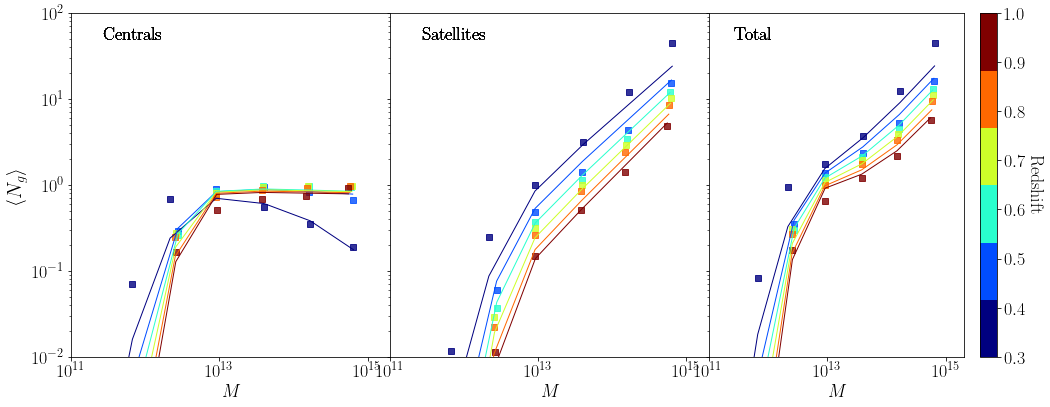

In [10]:
import matplotlib as mpl
nc_ns_final = get_Nc_Ns_theory_wz(np.array(z_all),x_cen,final_pos,np.amin(zcen_array))
nt = len(z_all)
nc_final = nc_ns_final[:nt]
ns_final = nc_ns_final[nt:]
fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
cmap = plt.get_cmap('jet',len(zcen_array))
texts = ['Centrals','Satellites','Total']
ki = 0

for jz in range(len(zcen_array)):
    M_cen = (out_dict['M_mean'][jz,:])
    n_cen = (out_dict['nc'][jz,:])
    M_sat = (out_dict['M_mean'][jz,:])
    n_sat = (out_dict['ns'][jz,:])
    ind_gtzero = np.where((M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0))[0]
    M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]
    kf = ki + len(M_cen)
    color =cmap(jz)
    for j in range(3):
        if j== 0:
            ax[j].plot(M_cen, n_cen,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color)  
            ax[j].errorbar(M_cen, nc_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 1:
            ax[j].plot(M_cen, n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
            ax[j].errorbar(M_cen, ns_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 2:
            ax[j].plot(M_cen, n_cen + n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
            ax[j].errorbar(M_cen, nc_final[ki:kf] + ns_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        ax[j].set_xlabel(r'$M$', size = 18)
        ax[j].set_ylim(1e-2,1e2)
        ax[j].set_xlim(1e11,2e15)
        ax[j].tick_params(axis='both', which='major', labelsize=18)
        ax[j].tick_params(axis='both', which='minor', labelsize=18)
    #     ax[j].legend(fontsize = 18, frameon = False)
        text = texts[j]
        ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    
    ki = kf
    
norm = mpl.colors.Normalize(vmin=np.amin(zcen_array),vmax=np.amax(zcen_array))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()
# fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_fit_HOD_fid_6params.pdf')








/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


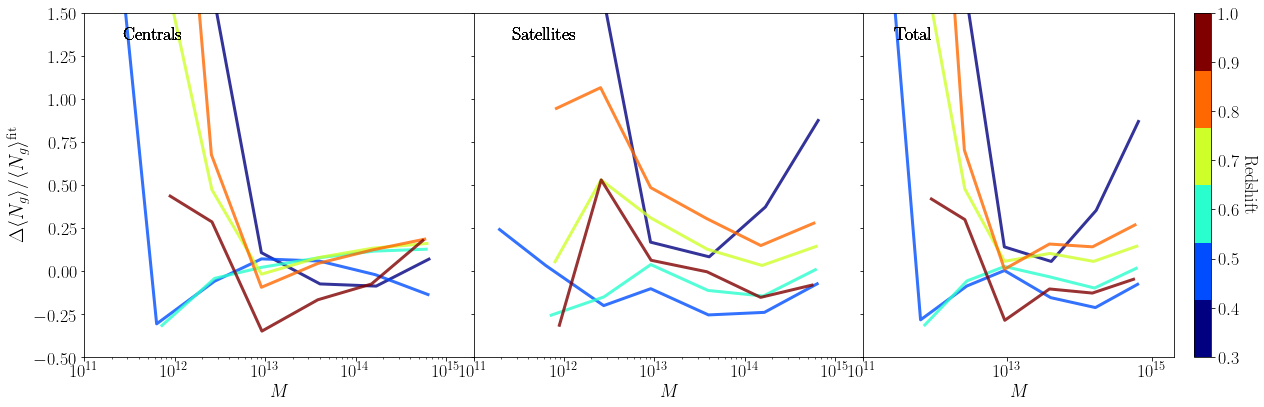

In [20]:
import matplotlib as mpl
nc_ns_final = get_Nc_Ns_theory_wz(np.array(z_all),x_cen,final_pos,np.amin(zcen_array))
nt = len(z_all)
nc_final = nc_ns_final[:nt]
ns_final = nc_ns_final[nt:]
fig, ax = plt.subplots(1,3, figsize = (18,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
cmap = plt.get_cmap('jet',len(zcen_array))
texts = ['Centrals','Satellites','Total']
ki = 0

for jz in range(len(zcen_array)):
    M_cen = (out_dict['M_mean'][jz,:])
    n_cen = (out_dict['nc'][jz,:])
    M_sat = (out_dict['M_mean'][jz,:])
    n_sat = (out_dict['ns'][jz,:])
    ind_gtzero = np.where((M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0))[0]
    M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]
    kf = ki + len(M_cen)
    color =cmap(jz)
    for j in range(3):
        if j== 0:
            ax[j].plot(M_cen, (n_cen - (nc_final[ki:kf]))/nc_final[ki:kf],ls='-',marker='',linewidth=3.0,alpha=0.8, color=color, mec=color)  
#             ax[j].errorbar(M_cen, nc_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 1:
            ax[j].plot(M_cen, (n_sat - ns_final[ki:kf])/ns_final[ki:kf],ls='-',marker='',linewidth=3.0,alpha=0.8, color=color, mec=color) 
#             ax[j].errorbar(M_cen, ns_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 2:
            ax[j].plot(M_cen, (n_cen + n_sat - nc_final[ki:kf] - ns_final[ki:kf])/(nc_final[ki:kf] + ns_final[ki:kf]),ls='-',marker='',linewidth=3.0,alpha=0.8, color=color, mec=color) 
#             ax[j].errorbar(M_cen, nc_final[ki:kf] + ns_final[ki:kf],ls='-',marker='',linewidth=1.0,color=color)   
        ax[j].set_xscale('log')
#         ax[j].set_yscale('log')
        ax[j].set_xlabel(r'$M$', size = 18)
#         ax[j].set_ylim(1e-2,1e2)
        ax[j].set_ylim(-0.5,1.5)
        ax[j].set_xlim(1e11,2e15)
        ax[j].tick_params(axis='both', which='major', labelsize=18)
        ax[j].tick_params(axis='both', which='minor', labelsize=18)
    #     ax[j].legend(fontsize = 18, frameon = False)
        text = texts[j]
        ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    
    ki = kf
    
norm = mpl.colors.Normalize(vmin=np.amin(zcen_array),vmax=np.amax(zcen_array))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\Delta \langle N_g \rangle/ \langle N_g \rangle^{\rm fit}$', size = 20)
plt.tight_layout()
# fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_fit_HOD_fid_6params.pdf')









In [151]:
logmminz0,siglogmz0,logmstarz0,nz0 = final_pos[0],final_pos[1],final_pos[2],final_pos[3]

logmminp,siglogmp,logmstarp,npow = final_pos[6],final_pos[7],final_pos[8],final_pos[9]

nm = len(x_cen)
nz = len(z_all)

logmmin = logmminz0 * ((1. + z_all) ** logmminp)
siglogm = siglogmz0 * ((1. + z_all) ** siglogmp)
logmstar = logmstarz0 * ((1. + z_all) ** logmstarp)
n = nz0 * ((1. + z_all) ** npow)

ncen1  = 0.5*( 1. + ss.erf((x_cen - logmmin)/siglogm) )
ncen  = ncen1 * (np.exp(-1.* np.power(((x_cen)/logmstar),n))) 




In [ ]:
# import matplotlib as mpl
# zcen_array_all = 0.5*(np.array(out_dict['zmin_array']) + np.array(out_dict['zmax_array']))

# jz_array_all = np.arange(len(zcen_array_all))

# jz_array = np.linspace(0,len(jz_array_all)-1,10).astype(int)
# zcen_array = zcen_array_all[jz_array]

# final_pos_mat = np.zeros((len(zcen_array),int(len(param_prior)/2)))

# fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
# # colors = ['red','blue','orange','black','green','magenta']
# cmap = plt.get_cmap('jet',len(zcen_array))
# texts = ['Centrals','Satellites','Total']
# M_arr = np.logspace(10,16,100)
# for jz in range(len(zcen_array)):
#     p0 = get_initial_state(nwalkers, param_prior)
#     print(zcen_array[jz])
#     M_cen = (out_dict['M_mean'][jz,:])
#     n_cen = (out_dict['nc'][jz,:])
#     M_sat = (out_dict['M_mean'][jz,:])
#     n_sat = (out_dict['ns'][jz,:])
#     ind_gtzero = np.where((M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0))[0]
#     M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]

#     x_cen = np.log10(M_cen)
#     y_cen = np.log10(n_cen)
#     x_sat = np.log10(M_sat)
#     y_sat = np.log10(n_sat)
#     hod_obs = np.hstack([n_cen,n_sat])
#     sigma = 0.01*hod_obs
#     cov_obs = np.diag(sigma**2)
#     inv_cov_obs = np.linalg.inv(cov_obs)
#     sampler = get_sampler(nwalkers, param_prior,x_cen, hod_obs, inv_cov_obs)
#     final_pos, final_pos_sigma, sampler = get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='most_like')  
#     final_pos_mat[jz,:] = final_pos
    
#     th_dv = get_Nc_Ns_theory(np.log10(M_arr),final_pos)


#     color =cmap(jz)
#     for j in range(3):
#         if j== 0:
#             ax[j].plot(M_cen, n_cen,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color)  
#             ax[j].errorbar(M_arr, th_dv[:100],ls='-',marker='',linewidth=1.0,color=color)   
#         if j== 1:
#             ax[j].plot(M_cen, n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
#             ax[j].errorbar(M_arr, th_dv[100:],ls='-',marker='',linewidth=1.0,color=color)   
#         if j== 2:
#             ax[j].plot(M_cen, n_cen + n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
#             ax[j].errorbar(M_arr, th_dv[:100] + th_dv[100:],ls='-',marker='',linewidth=1.0,color=color)   
#         ax[j].set_xscale('log')
#         ax[j].set_yscale('log')
#         ax[j].set_xlabel(r'$M$', size = 18)
#         ax[j].set_ylim(1e-2,1e2)
#         ax[j].set_xlim(1e11,2e15)
#         ax[j].tick_params(axis='both', which='major', labelsize=18)
#         ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     #     ax[j].legend(fontsize = 18, frameon = False)
#         text = texts[j]
#         ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


# norm = mpl.colors.Normalize(vmin=np.amin(zcen_array),vmax=np.amax(zcen_array))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# # plt.colorbar(sm, ticks=np.linspace(0,2,N), 
# #              boundaries=np.arange(-0.05,2.1,.1))
# cbar = plt.colorbar(sm)
# cbar.ax.get_yaxis().labelpad = 18
# cbar.ax.set_ylabel('Redshift', rotation=270)

# ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
# plt.tight_layout()
# fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_fit_HOD_diffz.pdf')




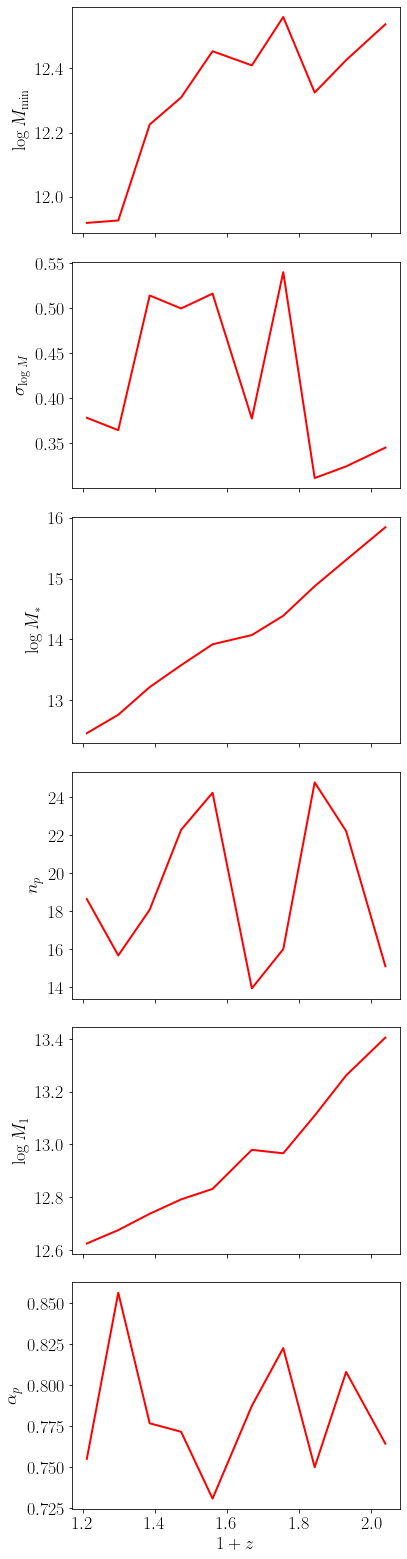

In [12]:

fig, ax = plt.subplots(6,1, figsize = (6,22),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
labels = [r'$\log{M_{\rm min}}$',r'$\sigma_{\log{M}}$',r'$\log{M_{*}}$',r'$n_p$',r'$\log{M_1}$',r'$\alpha_p$']
for j in range(6):
    ax[j].plot(1.+zcen_array, final_pos_mat[:,j],ls='-',marker='',linewidth=2.0,color='red')  
#     ax[j].plot(M_mean[j,:], ns_pl[j,:],ls='-',marker='.',linewidth=2.0,color=colors[j])
    # ax.errorbar(M_block,fv_cl,ls='--',marker='',elinewidth=2.0,color='red',label='Cl')

#     ax[j].set_xscale('log')
#     ax[j].set_yscale('log')
    ax[j].set_ylabel(labels[j], size = 18)
#     ax[j].grid(True)
#     ax[j].set_ylim(1e-4,5e1)
#     ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
ax[-1].set_xlabel(r'$1+z$', size = 18)
plt.tight_layout()








In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

zmin_cut = zmin_array
N = len(zmin_cut)
cmap = plt.get_cmap('jet',N)

texts = ['Centrals','Satellites','Total']

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
for j in range(3):
    k = 0
    for jz in range(len(zmin_array)):
        if (zmin_array[jz] > np.amin(zmin_cut)) and (zmin_array[jz] < np.amax(zmin_cut)):
            color =cmap(k)
            if j== 0:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 1:
                ax[j].plot(M_mean[jz,:], ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 2:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:] + ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)    
            k += 1

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
#     ax[j].grid(True)
    ax[j].set_ylim(1e-4,1e2)
    ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
    text = texts[j]
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


norm = mpl.colors.Normalize(vmin=np.amin(zmin_cut),vmax=np.amax(zmin_cut))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

# fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_maglim_hod_evolve_highz.pdf')


    
    

In [146]:
M_arr = np.logspace(10,16,100)
th_dv = get_Nc_Ns_theory(np.log10(M_arr),final_pos)



No handles with labels found to put in legend.


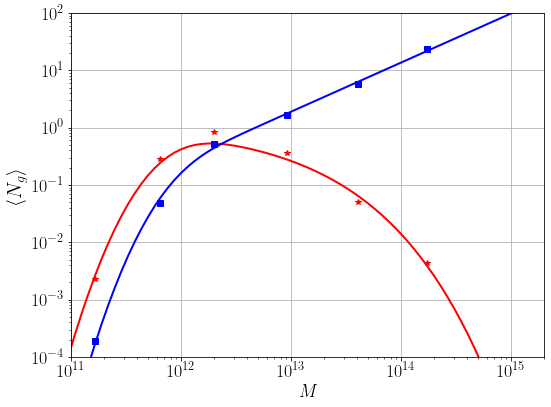

In [147]:


f1 = 10**(f_cen(np.log10(M_arr),12.5,0.5,0.5))
f2 = 10**(f_cen_exp(np.log10(M_arr),12.0,0.5,10.0,n=10))

fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']

ax.errorbar(M_cen, n_cen,ls='',marker='*',linewidth=2.0,color=colors[0])   
ax.errorbar(M_arr, th_dv[:100],ls='-',marker='',linewidth=2.0,color=colors[0])   
ax.errorbar(M_cen, n_sat,ls='',marker='s',linewidth=2.0,color=colors[1])   
ax.errorbar(M_arr, th_dv[100:],ls='-',marker='',linewidth=2.0,color=colors[1])   

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.set_ylim(1e-4,1e2)
ax.set_xlim(1e11,2e15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()









